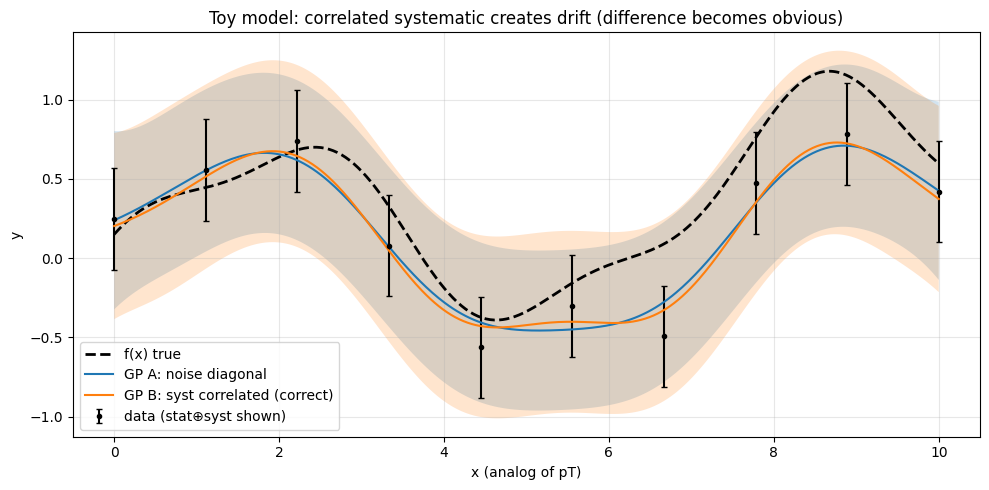

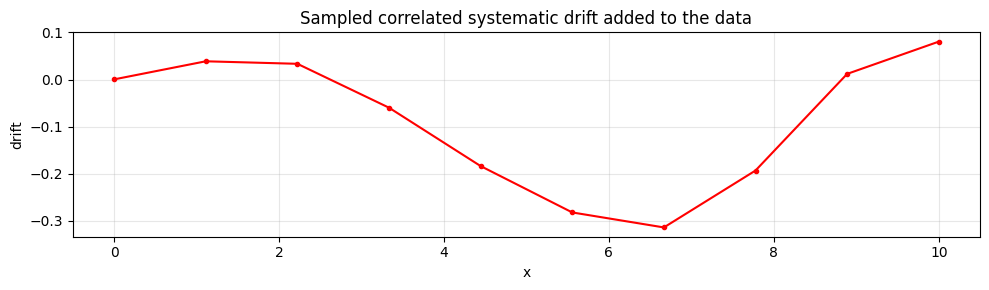

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# kernels
# -------------------------
def se_kernel(x, xp, sigma, ell):
    x = x.reshape(-1,1)
    xp = xp.reshape(-1,1)
    d2 = (x - xp.T)**2
    return (sigma**2) * np.exp(-0.5 * d2 / (ell**2))

# -------------------------
# GP posterior
# -------------------------
def gp_posterior(x, y, xs, K_func, Sigma_noise):
    Kxx = K_func(x, x)
    Kxs = K_func(x, xs)
    Kss = K_func(xs, xs)

    C = Kxx + Sigma_noise
    L = np.linalg.cholesky(C + 1e-10*np.eye(len(x)))

    v = np.linalg.solve(L, y)
    alpha = np.linalg.solve(L.T, v)

    mu = Kxs.T @ alpha

    w = np.linalg.solve(L, Kxs)
    cov = Kss - w.T @ w
    return mu, cov

# -------------------------
# 1) Dados sintéticos
# -------------------------
rng = np.random.default_rng(7)

# x em 1D (tipo pT)
x  = np.linspace(0, 10, 10)
xs = np.linspace(0, 10, 400)

# função verdadeira com estrutura
def ftrue(t):
    return 0.6*np.sin(0.9*t) + 0.15*np.cos(2.2*t) + 0.05*t

f = ftrue(x)

# ruído estatístico (i.i.d.)
sig_stat = 0.2 * np.ones_like(x)

# ruído sistemático correlacionado (drift suave)
sig_syst = 0.25 * np.ones_like(x)     # sistemático bem maior (pra ficar gritante)
ell_s    = 2.0                        # correlação longa -> drift
Ksys = se_kernel(x, x, sigma=1.0, ell=ell_s)  # correlação (norm)
# transforma em cov real: (sig_syst_i sig_syst_j) * corr
Sigma_syst = (sig_syst[:,None] * sig_syst[None,:]) * Ksys

# amostra um "drift" sistemático correlacionado
Lsys = np.linalg.cholesky(Sigma_syst + 1e-10*np.eye(len(x)))
drift = Lsys @ rng.normal(size=len(x))

# observa y
y = f + drift + rng.normal(scale=sig_stat, size=len(x))

# -------------------------
# 2) Dois modelos para o ruído (igual ao seu caso real)
# -------------------------
# Modelo A: matriz de correlação diagonal (stat+syst em quadratura)
Sigma_A = np.diag(sig_stat**2 + sig_syst**2)

# Modelo B: matriz de correlação erro statístico diagonal + m. corr. erro systemático correlacionado (correto)
Sigma_B = np.diag(sig_stat**2) + Sigma_syst

# -------------------------
# 3) Kernel do "sinal" (mesmo nos dois)
# -------------------------
sigma_f = 0.8
ell_f   = 1.3
Kf = lambda a,b: se_kernel(a,b,sigma=sigma_f,ell=ell_f)

muA, covA = gp_posterior(x, y, xs, Kf, Sigma_A)
muB, covB = gp_posterior(x, y, xs, Kf, Sigma_B)

stdA = np.sqrt(np.clip(np.diag(covA), 0, np.inf))
stdB = np.sqrt(np.clip(np.diag(covB), 0, np.inf))

# -------------------------
# 4) Plot (diferença gritante)
# -------------------------
plt.figure(figsize=(10,5))

# verdade
plt.plot(xs, ftrue(xs), 'k--', linewidth=2, label="f(x) true")

# dados
plt.errorbar(x, y, yerr=np.sqrt(sig_stat**2 + sig_syst**2),
             fmt='k.', capsize=2, label="data (stat⊕syst shown)")

# GP A
plt.plot(xs, muA, label="GP A: noise diagonal")
plt.fill_between(xs, muA-2*stdA, muA+2*stdA, alpha=0.2)

# GP B
plt.plot(xs, muB, label="GP B: syst correlated (correct)")
plt.fill_between(xs, muB-2*stdB, muB+2*stdB, alpha=0.2)

plt.xlabel("x (analog of pT)")
plt.ylabel("y")
plt.title("Toy model: correlated systematic creates drift (difference becomes obvious)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# opcional: visualizar o drift
plt.figure(figsize=(10,3))
plt.plot(x, drift, 'r.-')
plt.title("Sampled correlated systematic drift added to the data")
plt.xlabel("x")
plt.ylabel("drift")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()